In [4]:
import numpy as np
import pickle as pkl
import os
import timesynth as ts
from scipy.io import arff
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
import torch.utils.data as utils
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, roc_auc_score
from scipy.special import expit
from scipy.signal import butter, lfilter, freqz
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import *

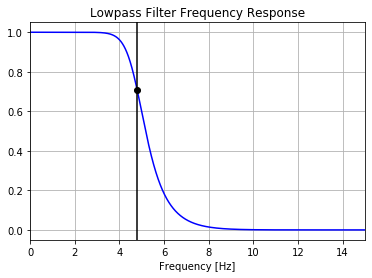

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 4.8 # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

w, h = freqz(b, a, worN=8000)
plt.subplot(1, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [3]:
def process_data(dataff):
    n_samples = len(data)
    n_features = len(dataff[0][0])
    T = len(dataff[0][0][0])
    Xx = np.zeros((n_samples, n_features, T))
    for n in range(n_samples):
        Xf = data[n][0]
        for feat in range(n_features):
            Xx[n, feat, :] = np.array([Xf[feat][t] for t in range(T)]).astype(float)
    yy = np.array([dataff[n][1] for n in range(n_samples)])
    return Xx, yy

with open('./data/DuckDuckGeese/DuckDuckGeese_TEST.arff', 'r') as f:
    data, meta = arff.loadarff(f)
    X_test, y_test = process_data(data)
    
with open('./data/DuckDuckGeese/DuckDuckGeese_TRAIN.arff', 'r') as f:
    data, meta = arff.loadarff(f)
    X_train, y_train = process_data(data)
    
ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

with open('./data/ddg/ddg.pkl','wb') as f:
    pkl.dump({'Xtrain': X_train, 'ytrain': y_train, 'Xtest': X_test, 'ytest': y_test,'enc': ohe}, f)

NameError: name 'pkl' is not defined

In [6]:
def softmax(latent_in):
    prob_mat = np.exp(latent_in)/np.sum(np.exp(latent_in),axis=0)
    return prob_mat

def logistic(latent_in):
    return expit(latent_in)
    
def generate_sample(seeds, Tt=80):
    latent = np.zeros((len(seeds),Tt))
    for k,seed in enumerate(seeds):
        gp = ts.signals.GaussianProcess(lengthscale=seed,mean=0)
        latent[k,:] = gp.sample_vectorized(time_vector=np.array(range(Tt)))
        latent[k,:] = butter_lowpass_filter(latent[k,:], cutoff, fs, order)
        latent[k,:] = logistic(latent[k,:])
        latent[k,:] = np.array([np.random.binomial(n=1,p=x,size=1) for x in latent[k,:]]).flatten()
    return latent

In [7]:
with open('./data/ddg/ddg.pkl','rb') as f:
    data_dict = pkl.load(f)
    
X_train = data_dict['Xtrain']
y_train = data_dict['ytrain'] 
X_test = data_dict['Xtest']
y_test = data_dict['ytest']

In [8]:
_, train_loader, valid_loader, test_loader = load_simulated_data(X_train, y_train, X_test, y_test, batch_size=40, percentage=1.)

In [ ]:
encoding_size=80
feature_size = X_train.shape[1]
n_classes = y_train.shape[1]
data='ddg'
exp = EncoderPredictor(train_loader, valid_loader, test_loader, feature_size, encoding_size,
                               rnn_type='LSTM', data=data, model='RNN',n_classes=n_classes)
exp.run(train=True, n_epochs=300, samples_to_analyze=[])

In [11]:
# For all train/test samples, do inference with masked features
n_samples, n_features, Tt = X_train.shape
n_basis=5000
candidate_probs = generate_sample(np.random.normal(loc=2,scale=1,size=n_basis), Tt=Tt)#dump new labels with ground-truth feature importance tensor

In [12]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(np.reshape(X_train,[X_train.shape[0],-1]))
X_train = np.reshape(X_train_flat,X_train.shape)
X_test_flat = scaler.transform(np.reshape(X_test,[X_test.shape[0],-1]))
X_test = np.reshape(X_test_flat,X_test.shape)

X_train_new = np.zeros(X_train.shape)
feature_imp_train = np.zeros(X_train.shape)
for n in range(X_train.shape[0]):
    hide_idx = np.random.choice(n_basis,replace=True,size=n_features)
    mask_mat = candidate_probs[hide_idx,:]
    X_train_new[n,:,:] = np.multiply(X_train[n,:,:], mask_mat)
    feature_imp_train[n,:,:] = mask_mat
    
X_test_new = np.zeros(X_test.shape)
feature_imp_test = np.zeros(X_test.shape)
for n in range(X_test.shape[0]):
    hide_idx = np.random.choice(n_basis,replace=True,size=n_features)
    mask_mat = candidate_probs[hide_idx,:]
    X_test_new[n,:,:] = np.multiply(X_test[n,:,:],mask_mat)
    feature_imp_test[n,:,:] = mask_mat
    
train_dataset = utils.TensorDataset(torch.Tensor(X_train_new[:, :, :]),torch.Tensor(y_train[:, :]))
valid_dataset = utils.TensorDataset(torch.Tensor(X_train_new[:, :, :]),torch.Tensor(y_train[:, :]))
test_dataset = utils.TensorDataset(torch.Tensor(X_test_new[:,:,:]), torch.Tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=len(X_train))
valid_loader = DataLoader(valid_dataset, batch_size=len(X_train))
test_loader = DataLoader(test_dataset, batch_size=len(X_test))

In [14]:
feature_size = X_train_new.shape[1]
n_classes = y_train.shape[1]
data='ddg'
exp = EncoderPredictor(train_loader, valid_loader, test_loader, feature_size, encoding_size,
                               rnn_type='LSTM', data=data, model='RNN',n_classes=n_classes)
y_train_new, logits_train_new, y_test_new, logits_test_new = exp.run(train=False, n_epochs=130)

In [15]:
if not os.path.exists('./data/ddg'):
    os.mkdir('./data/ddg')
with open('./data/ddg/x_train.pkl', 'wb') as f:
    pkl.dump(X_train_new, f)
with open('./data/ddg/x_test.pkl', 'wb') as f:
    pkl.dump(X_test_new, f)
with open('./data/ddg/y_train.pkl', 'wb') as f:
    pkl.dump(y_train_new, f)
with open('./data/ddg/y_test.pkl', 'wb') as f:
    pkl.dump(y_test_new, f)
with open('./data/ddg/importance_train.pkl', 'wb') as f:
    pkl.dump(feature_imp_train, f)
with open('./data/ddg/importance_test.pkl', 'wb') as f:
    pkl.dump(feature_imp_test, f)
with open('./data/ddg/logits_train.pkl', 'wb') as f:
    pkl.dump(logits_train_new, f)
with open('./data/ddg/logits_test.pkl', 'wb') as f:
    pkl.dump(logits_test_new, f)


Epoch 0
Training ===>loss:  1.6018776893615723  Accuracy: 26.00 percent  AUC: 0.58
Test ===>loss:  1.6081126928329468  Accuracy: 24.00 percent  AUC: 0.55

Epoch 10
Training ===>loss:  1.5991302728652954  Accuracy: 28.00 percent  AUC: 0.56
Test ===>loss:  1.6017775535583496  Accuracy: 30.00 percent  AUC: 0.71

Epoch 20
Training ===>loss:  1.5941047668457031  Accuracy: 28.00 percent  AUC: 0.59
Test ===>loss:  1.5922441482543945  Accuracy: 56.00 percent  AUC: 0.80

Epoch 30
Training ===>loss:  1.5824352502822876  Accuracy: 34.00 percent  AUC: 0.71
Test ===>loss:  1.5824283361434937  Accuracy: 60.00 percent  AUC: 0.86

Epoch 40
Training ===>loss:  1.5882333517074585  Accuracy: 36.00 percent  AUC: 0.64
Test ===>loss:  1.573480248451233  Accuracy: 66.00 percent  AUC: 0.90

Epoch 50
Training ===>loss:  1.5798405408859253  Accuracy: 30.00 percent  AUC: 0.73
Test ===>loss:  1.5647149085998535  Accuracy: 70.00 percent  AUC: 0.92

Epoch 60
Training ===>loss:  1.5735254287719727  Accuracy: 38.00 

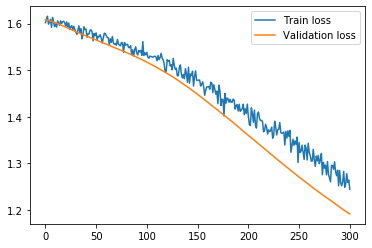

In [16]:
train_dataset = utils.TensorDataset(torch.Tensor(X_train_new[:, :, :]),torch.Tensor(y_train_new[:, :]))
valid_dataset = utils.TensorDataset(torch.Tensor(X_train_new[:, :, :]),torch.Tensor(y_train_new[:, :]))
test_dataset = utils.TensorDataset(torch.Tensor(X_test_new[:,:,:]), torch.Tensor(y_test_new))
train_loader = DataLoader(train_dataset, batch_size=len(X_train_new))
valid_loader = DataLoader(valid_dataset, batch_size=len(X_train_new))
test_loader = DataLoader(test_dataset, batch_size=len(X_test_new))
exp = EncoderPredictor(train_loader, valid_loader, test_loader, feature_size, 50,
                               rnn_type='LSTM', data=data, model='RNN',n_classes=n_classes)
exp.run(train=True, n_epochs=300)